# Text Classification - From Scratch Vs Transfer Learning

In [3]:
import numpy as np
import re
import string

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data loading and exploration

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

## Explore the data

In [5]:
print("Training entries: {}, Test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, Test entries: 25000


In [6]:
#First 10 examples 
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [7]:
#First 10 labels
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## How to use the Embedding layer

In [8]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [9]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.02201141,  0.04651872,  0.01343712,  0.03976868, -0.00239991],
       [-0.02989044,  0.00495751,  0.02155885, -0.04124289, -0.03661578],
       [ 0.01352936, -0.00572624,  0.03997752,  0.03457144, -0.02392248]],
      dtype=float32)

In [10]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
print(result.shape)
result[0]

(2, 3, 5)


<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[-0.0109519 ,  0.03464807,  0.0421868 , -0.0384916 , -0.02750307],
       [ 0.02201141,  0.04651872,  0.01343712,  0.03976868, -0.00239991],
       [-0.02989044,  0.00495751,  0.02155885, -0.04124289, -0.03661578]],
      dtype=float32)>

## 1. Building the Model from scratch

In [11]:
 len(train_data)

2

- **Creating a validation set**

In [12]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

- **Text processing**

In [13]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(partial_x_train)

- **Model building**

In [14]:
embedding_dim=16


scratch_model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

- **Compile the model**

In [15]:
scratch_model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

- **Model training**

In [16]:
history = scratch_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 1s 40ms/step - loss: 0.6912 - accuracy: 0.5771 - val_loss: 0.6880 - val_accuracy: 0.6176
Epoch 2/5
30/30 [==============================] - 1s 34ms/step - loss: 0.6825 - accuracy: 0.6753 - val_loss: 0.6769 - val_accuracy: 0.6789
Epoch 3/5
30/30 [==============================] - 1s 33ms/step - loss: 0.6663 - accuracy: 0.7055 - val_loss: 0.6579 - val_accuracy: 0.7238
Epoch 4/5
30/30 [==============================] - 1s 36ms/step - loss: 0.6401 - accuracy: 0.7455 - val_loss: 0.6296 - val_accuracy: 0.7387
Epoch 5/5
30/30 [==============================] - 1s 36ms/step - loss: 0.6028 - accuracy: 0.7729 - val_loss: 0.5939 - val_accuracy: 0.7661


In [17]:
scratch_history_dict = history.history

## 2. Building the model using transfer learning

In [18]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(model_url, output_shape=[512], input_shape=[], 
                           dtype=tf.string, trainable=False)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 512), dtype=float32, numpy=
array([[ 0.0407019 ,  0.00420413, -0.01570059, ..., -0.02733917,
         0.07720678, -0.0280135 ],
       [ 0.02308331,  0.03450441,  0.0319173 , ..., -0.00709982,
         0.09138072,  0.00642447],
       [ 0.02236585, -0.00636594,  0.04310483, ..., -0.04315185,
         0.05988497,  0.02873518]], dtype=float32)>

- **Let's now build the full model with transfer learning**

In [19]:
transfer_model = tf.keras.Sequential()
transfer_model.add(hub_layer)
transfer_model.add(tf.keras.layers.Dense(16, activation='relu'))
transfer_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 256,806,049
Trainable params: 8,225
Non-trainable params: 256,797,824
_________________________________________________________________


In [20]:
scratch_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


- **Loss function and optimizer**

In [21]:
transfer_model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

- **Train the model**

In [22]:
history = transfer_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 26s 864ms/step - loss: 0.6696 - accuracy: 0.6643 - val_loss: 0.6277 - val_accuracy: 0.7849
Epoch 2/5
30/30 [==============================] - 26s 868ms/step - loss: 0.5838 - accuracy: 0.7967 - val_loss: 0.5421 - val_accuracy: 0.8070
Epoch 3/5
30/30 [==============================] - 25s 837ms/step - loss: 0.5052 - accuracy: 0.8167 - val_loss: 0.4766 - val_accuracy: 0.8233
Epoch 4/5
30/30 [==============================] - 26s 864ms/step - loss: 0.4498 - accuracy: 0.8300 - val_loss: 0.4329 - val_accuracy: 0.8304
Epoch 5/5
30/30 [==============================] - 25s 847ms/step - loss: 0.4128 - accuracy: 0.8378 - val_loss: 0.4031 - val_accuracy: 0.8380


- **Evaluate the model**

In [23]:
scratch_model.metrics_names

['loss', 'accuracy']

In [24]:
results_fs = scratch_model.evaluate(test_data, test_labels)
results_t = transfer_model.evaluate(test_data, test_labels)
print(results_fs)
print(results_t)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


782/782 [==============================] - 26s 33ms/step - loss: 0.4021 - accuracy: 0.8366
[0.5996083617210388, 0.7558799982070923]
[0.40211644768714905, 0.8365600109100342]


- **Graph of accuracy and loss over time**

In [25]:
transfer_history_dict = history.history
transfer_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

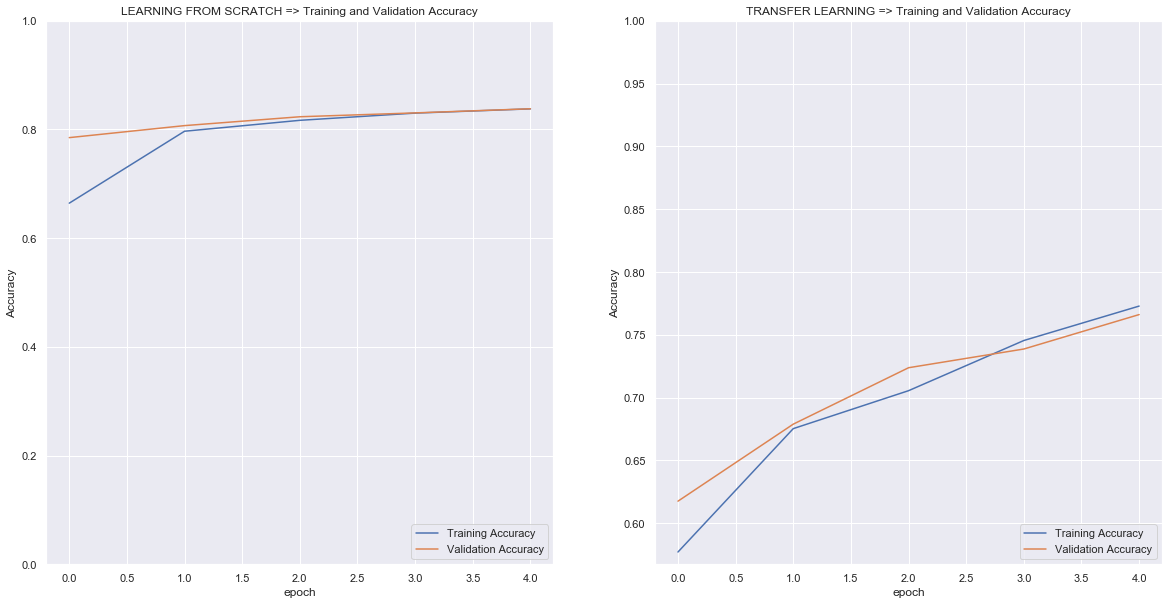

In [26]:
fig,axes = plt.subplots(1, 2,figsize=(20, 10))

axes[0].plot(transfer_history_dict['accuracy'], label='Training Accuracy')
axes[0].plot(transfer_history_dict['val_accuracy'], label='Validation Accuracy')
axes[0].legend(loc='lower right')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([min(plt.ylim()),1])
axes[0].set_title('LEARNING FROM SCRATCH => Training and Validation Accuracy')
axes[0].set_xlabel('epoch')

axes[1].plot(scratch_history_dict['accuracy'], label='Training Accuracy')
axes[1].plot(scratch_history_dict['val_accuracy'], label='Validation Accuracy')
axes[1].legend(loc='lower right')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([min(plt.ylim()),1])
axes[1].set_title('TRANSFER LEARNING => Training and Validation Accuracy')
axes[1].set_xlabel('epoch')
plt.show()

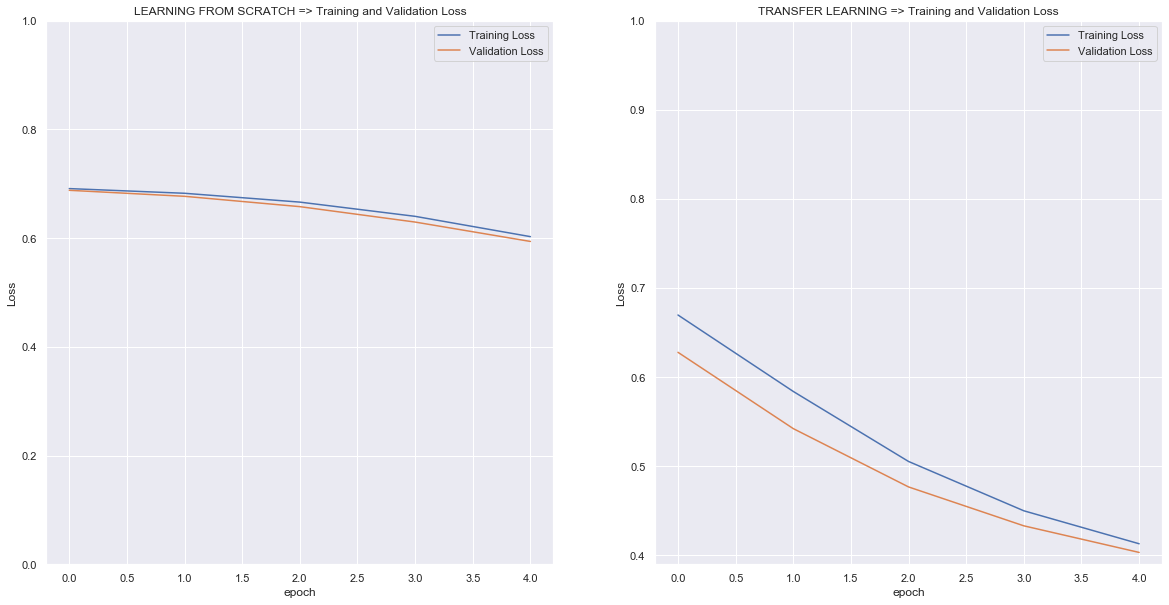

In [27]:
fig,axes = plt.subplots(1, 2,figsize=(20, 10))

axes[0].plot(scratch_history_dict['loss'], label='Training Loss')
axes[0].plot(scratch_history_dict['val_loss'], label='Validation Loss')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('Loss')
axes[0].set_ylim([min(plt.ylim()),1])
axes[0].set_title('LEARNING FROM SCRATCH => Training and Validation Loss')
axes[0].set_xlabel('epoch')

axes[1].plot(transfer_history_dict['loss'], label='Training Loss')
axes[1].plot(transfer_history_dict['val_loss'], label='Validation Loss')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('Loss')
axes[1].set_ylim([min(plt.ylim()),1])
axes[1].set_title('TRANSFER LEARNING => Training and Validation Loss')
axes[1].set_xlabel('epoch')
plt.show()